<h1>Using Deep Q Learning to train RL agent to play CartPole-v1<h1>

The goal of the game is to continuously decide between two moves left or right so that the attached pole remains straightup

I have already installed gymnasium for environment. Please install this if not already present using pip3 install gymnasium[classic_control].


Also install other dependencies if required

In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
#importing pytorch 
import torch
import torch.nn as nn #neural networks
import torch.optim as optim #optimization
import torch.nn.functional as F
from IPython import display
env = gym.make("CartPole-v1")
#setting up matpoltlib
plt.ion()
device="cpu"
#i was not able to use the gpu 


The state in cartpole consists of four values<br>
Cart Position<br>
Cart Velocity<br>
Pole Angle<br>
Pole Angular Velocity<br>

Now here we define class replay memory to store experience tuples(Transition). It has a upper bound on number of transition stored(so i used double ended queue)

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#this named tuple represent a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward)


class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  

    def push(self, *args):
        #pushing a transition
        self.memory.append(Transition(*args))
        #When you use *args in the function definition, it allows the function to accept any number of positional arguments.

    def sample(self, batch_size):
        #getting a random sample out of our memory of given length
        return random.sample(self.memory, batch_size)

    def __len__(self):
        #Return the current size of internal memory
        return len(self.memory)

Our model is a feedforward neural network that takes the difference between the current and previous screen patches as input. It has two outputs, representing 
𝑄(𝑠,left) and Q(s,right), where s is the input to the network. Essentially, the network aims to predict the expected return of taking each action given the current input.

Here we initialise our neural network class. I used relu to introduce some non linearity

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

number of transition sampled from replay buffer is batch size <br>
gamma is discount factor<br>
eps start and end are initial and final value of epsilon<br>
eps decay is the rate of exponential decay of epsilon<br>
tau(the greek symbol) is the update rate of target network<br>
lr is the learning rate of adamW optimiser

The select_action function will choose an action based on an epsilon-greedy policy. This means that sometimes the action will be selected using our model, and other times a random action will be chosen uniformly. The probability of selecting a random action begins at EPS_START and decays exponentially towards EPS_END, with EPS_DECAY controlling the rate of this decay.

plot duration function plots the duration of each episode and average of last 100 episode(which we use in evaluation)

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space(it is 2 in our case)
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device) # main network used for selecting actions during training
target_net = DQN(n_observations, n_actions).to(device) #used to compute the target Q-values
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR) #we used adam optimiser
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
            #in short here the policy network is used to select the action with the highest Q-value.
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long) 
        #a random action is selected using the environment's action space.


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.0001)  # pause a bit so that plots are updated
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

the optimise model function perform single step of optimisation. V(s) = 0 if s is a terminal state.The target network is updated at every step with a soft update controlled by the hyperparameter TAU.

1. Sample a batch of experiences.
2. Concatenate tensors into a single one.
3. Compute Q</sub>(s<sub>t</sub>, a<sub>t</sub>) using the policy network.
4. Compute V<sub>t+1</sub>(s<sub>t+1</sub>) = max<sub>a</sub> Q(s<sub>t+1</sub>, a) using the target network.
5. Combine into the loss.


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Now when everything is set we can finally train our agent on as many episodes as we require

Complete


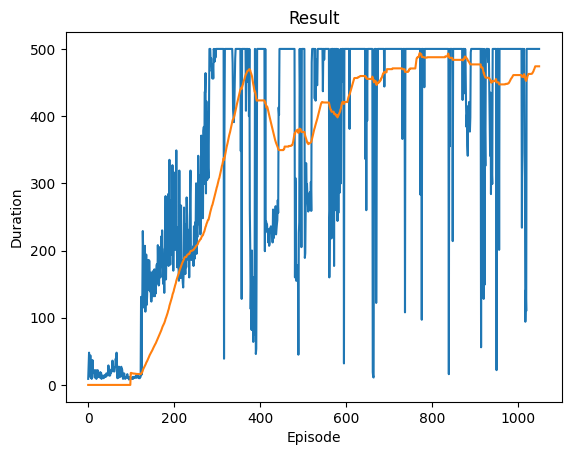

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

After training the agent use the code below to run it to see the result.

In [16]:
env = gym.make('CartPole-v1', render_mode='human')


state,info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
done = False
score = 0

while not done:
    env.render()  # Ensure rendering happens inside the loop
    action = select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    done = terminated or truncated
    score += reward
    state = next_state

print('Score: {}'.format(score))

env.close() 

Score: 500.0
